AUTHORS : 
Amélie SCIBERRAS
Marianne DEFRESNES

# Importation nécessaires : 

In [1]:
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import matplotlib.image as mpimg
from PIL import ImageFilter
import cv2 
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import scipy.signal
from PIL import Image
import imageio

from skimage.morphology import watershed, disk, label
from skimage import data
from skimage.filters import rank
from skimage.filters.rank import minimum
from skimage.util import img_as_ubyte

# necessite scikit-image 
from skimage import io as skio


# POUR LA MORPHO
from skimage.morphology import watershed 
from skimage.feature import peak_local_max
from skimage import transform as skitr

#pour les closings
from skimage.viewer import ImageViewer
from skimage import morphology as mph
from skimage.filters.rank import median
from skimage.morphology import disk

#flouter 
def get_gau_ker(s):
    ss=int(max(3,2*np.round(2.5*s)+1))
    ms=(ss-1)//2
    X=np.arange(-ms,ms+0.99)
    y=np.exp(-X**2/2/s**2)
    out=y.reshape((ss,1))@y.reshape((1,ss))
    out=out/out.sum()
    return out

def get_cst_ker(t):
    return np.ones((t,t))/t**2

def filtre_lineaire(im,mask):
    """ renvoie la convolution de l'image avec le mask. Le calcul se fait en 
utilisant la transformee de Fourier et est donc circulaire.  Fonctionne seulement pour 
les images en niveau de gris.
"""
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)*fft2(mm))
    # on fait une translation pour ne pas avoir de decalage de l'image
    # pour un mask de taille impair ce sera parfait, sinon, il y a toujours un decalage de 1/2
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*np.conj(fft2(mm))))
    return out


C:\Users\amelie\Anaconda3\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


### Contour du crâne

In [2]:
def seuil(im,valeur): #attention la valuer attendue correspond à un pourcentage (conseil :70)
    im=scipy.signal.medfilt(im,3)
    valeur=np.percentile(im,valeur)
    [M,N]=np.shape(im)
    im_seuil=np.zeros((M,N))
    for i in range (M):
        for j in range(N):
            if im[i,j]>valeur:
                im_seuil[i,j]=1
            else:
                im_seuil[i,j]=0
    return(im_seuil)

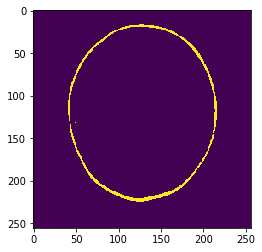

In [3]:
def contour_crane(im,pourc):
    im=seuil(im,pourc)
    M,N=np.shape(im)
    mini=max(M,N)
    maxi=0
    L=np.zeros((M,N))
    pixel=0
    #on parcourt la liste ligne par ligne et on cherche le premier pixel blanc
    for i in range(M):
        for j in range (N):
            pixel=im[i,j]
            if pixel>0:
                if j<mini:
                    mini=j
                    L[i,j]=1
                    k=0
                    while im[i,j+k]!=0: #on prend tous les voisins
                        L[i,j+k]=1
                        k=k+1
        #on parcourt la ligne à l'envers pour avoir le dernier pixel blanc
        for j in range(N-1,-1,-1):
            pixel=im[i,j]
            if pixel>0:
                if j>maxi:
                    maxi=j
                    L[i,j]=1
                    k=0
                    while im[i,j-k]!=0: #on prend tous les voisins
                        L[i,j-k]=1
                        k=k+1
        mini=max(M,N)
        maxi=0
        
    #on élimine les points qui n'ont pas au moins 2 voisins blancs (erreur si seuil trop lache : trou dans le contour)
    voisin=[]
    c=0
    for i in range (M):
        for j in range (N):
            if L[i,j]==1:
                voisin=[L[i-1,j-1],L[i-1,j],L[i,j-1],L[i+1,j+1],L[i+1,j],L[i,j+1],L[i-1,j+1],L[i+1,j-1]]
                for k in range (8):
                    if voisin[k]==1:
                        c=c+1
                if c<2:
                    L[i,j]=0
                c=0
            
    return(L)

im=mpimg.imread('Image1Coupe10.png')
plt.imshow(contour_crane(im,70))

### Extraction du cerveau

In [4]:
#retourne une image
def envers(im2):
    M,N=np.shape(im2)
    im2bis=np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            im2bis[M-i-1][N-j-1]=im2[i,j]
    return(im2bis)

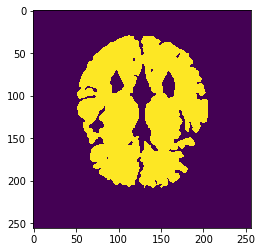

In [5]:
#compo c-connexes
import scipy.ndimage.filters as filt

def compo_connexe(im,c):
    [N,M]=np.shape(im)
    etiq=np.zeros((N,M))
    pixel=0
    compt=1
    Vmin=N*M+1 #valeur inateignale vu qu'il ya N*M pixels
    tabl_etiq=[[0,0]] #tableau des classes d'étiquettes
    voisin=[]#etiquettes de c voisins d'un point
    for i in range(1,N-1):
        for j in range(1,M-1):
            pixel=im[i,j]
            if c==8:
                voisin=[etiq[i-1,j-1],etiq[i-1,j],etiq[i,j-1],etiq[i-1,j+1]]
                #voisin=[etiq[i-1,j-1],etiq[i-1,j],etiq[i,j-1],etiq[i+1,j+1],etiq[i+1,j],etiq[i,j+1],etiq[i-1,j+1],etiq[i+1,j-1]]
            if c==4:
                voisin=[etiq[i-1,j],etiq[i,j-1]]
                #voisin=[etiq[i-1,j],etiq[i,j-1],etiq[i+1,j],etiq[i,j+1]]
            if pixel!=0:
                for k in range(int(c/2)):
                    if voisin[k]!=0 and voisin[k]<Vmin:
                        Vmin=voisin[k]; #min des etiquettes voisines hormis 0
                if Vmin==N*M+1: #tous les voisins sont noirs
                    etiq[i,j]=compt
                    tabl_etiq.append([compt,compt])
                    compt=compt+1
                else:
                    etiq[i,j]=Vmin
                    for k in range(int(c/2)): #modif
                        if voisin[k]!=0:
                            tabl_etiq[int(voisin[k])][1]=Vmin
            Vmin=N*M+1#verifier indentation
    #on met à jour etiq grâce à tabl_etiq
    Cmax=[0*i for i in range (len(tabl_etiq))]#permet d'avoir la compo max (attention en 0, tous les points noirs)
    for i in range(N):
        for j in range(M):
            while(etiq[i,j]!=tabl_etiq[int(etiq[i,j])][1]):
                etiq[i,j]=tabl_etiq[int(etiq[i,j])][1]
            Cmax[int(etiq[i,j])]=Cmax[int(etiq[i,j])]+1
    #print(np.shape(tabl_etiq))#affiche le nombre de compo connexes
    
    return([etiq,Cmax])

#[contour,Cmax]=compo_connexe(binarize(test,10),8)
#print(Cmax)

def affich_Cmax_theo(im,c):
    [im,Cmax]=compo_connexe(im,c)
    imax=0 #etiquette de la compo max 
    valmax=0
    for i in range(1,len(Cmax)):
        if Cmax[i]>valmax:
            imax=i
            valmax=Cmax[i]
    [N,M]=np.shape(im)
    for i in range(N):
        for j in range(M):
            if im[i][j]==imax:
                im[i][j]=255
            else:
                im[i][j]=0
    return(im)

def affich_Cmax(im,c): #on fait affich-Cmax_theo sur l'image et et l'image à l'envers et on somme
    compo1=affich_Cmax_theo(im,c)
    compo2=envers(affich_Cmax_theo(envers(im),c))
    compo=compo1+compo2
    return(seuil(compo,10))

plt.imshow(affich_Cmax(seuil(im,70),8))

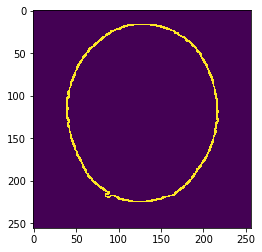

In [6]:
def negative (im):
    M,N=np.shape(im)
    I=np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            if im[i,j]==0:
                I[i,j]=1
            else:
                I[i,j]=0
    return(I)

def bouche_trou(im):
    im=negative(im)
    compo=label(im)
    M,N=np.shape(compo)
    Cbord=compo[0][0]
    
    for i in range (M):
        for j in range(N):
            if compo[i][j]>0 and compo[i][j]!=Cbord:
                compo[i,j]=0
    return(negative(compo))

def dessinercontour(labels) :
    contours=np.zeros(labels.shape)
    for i in range(labels.shape[0]-1) : 
        for j in range(labels.shape[0]-1) :  ##les abc etc correspondent aux pixels voisins de labels[i][j]
            a=labels[i][j+1] !=labels[i][j]
            b=labels[i+1][j+1] !=labels[i][j]
            c=labels[i-1][j+1] !=labels[i][j]
            d=labels[i+1][j] !=labels[i][j]
            e=labels[i-1][j] !=labels[i][j]
            f=labels[i][j-1] !=labels[i][j]
            g=labels[i+1][j-1] !=labels[i][j]
            h=labels[i-1][j-1] !=labels[i][j]
            
            if(a or b or c or d or e or f or g or h ) : 
                contours[i][j]=1  
    return contours

#img=mpimg.imread('Image1Coupe15.png')
#img=mpimg.imread('T2011NB.png')
def contour_crane2(img,pourc): #prendre 60 pour Image1Coupe10 et 70 pour T2010NB
    tala=seuil(img,pourc)
    tala=bouche_trou(tala)
    tala=affich_Cmax(tala,4)
    tala=dessinercontour(tala)
    return(tala)

plt.imshow(contour_crane2(im,60))

### Séparation des hémisphères

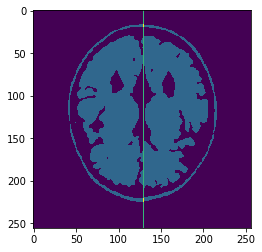

In [7]:
def ligne_hemi(im):
    demi=affich_Cmax(seuil(im,75),8) #on augment le seuil pour séparer les hémisphères et donc obtenir une hémisphère avec Cmax
    M,N=np.shape(demi)
    #postulat : cerveau centré donc pixels non noirs à partir de j=100
    jmax=100
    compt=1
    while compt>0:
        compt=0
        for i in range(M):
            if demi[i,jmax]>0:
                compt=compt+1
        jmax=jmax+1
    return(jmax) # on retourne l'abscisses de la meilleure ligne de séparation

#affiche le cerveau, le contour et la ligne séparant les hémishphères
def affich_ligne(im):
    M,N=np.shape(im)
    jmax=ligne_hemi(im)
    ima=affich_Cmax(seuil(im,70),8)
    for i in range(M):
        ima[i,jmax]=2
    plt.imshow(ima+contour_crane(im,70))

affich_ligne(im)

### Somme des fermetures

In [8]:
image =skio.imread('Image1Coupe10.png')


#plt.imshow(image)
#texte de la publi : sum of increasing scale 
def incrclosing(k,n,pas,image) : 
  
    s=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(k,k))
    sum=mph.closing(image,s)
    for i in range(k+1,n+1,pas) : 
        s=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(i,i))
        img=mph.closing(image,s)
        img=median(img, disk(3))
        sum+=img
    
    sum=median(sum, disk(3))
    return sum

sumTOT= incrclosing(1,50,3,image)

#tu as ici un outil utile pour afficher en grand : 
#viewer = ImageViewer(sumTOT)
#viewer.show()


### Travail sur les marqueurs

#### marqueurs d'intérêts


In [9]:
def trouv_mark_noyaux(markers) : 

    kxg=int((markers.shape)[1]/2)
    kxd=int((markers.shape)[1]/2)
    kyg=int((markers.shape)[1]/2)
    kyd=int((markers.shape)[1]/2)
    middle=int((markers.shape)[1]/2)
    
    l=[]  #liste des marqueurs intéressants
        #partie gauche en premier
    while (markers[kxg,kyg]==markers[middle][middle])and(kxg!=0) : 
        kxg-=1
        kyg-=1
    l.append(markers[kxg][kyg])
     #partie droite
    while (markers[kxd,kyd]==markers[middle][middle])and(kxd!=0) : 
        kxd+=1
        kyd+=1
    l.append(markers[kxd][kyd])
    
    print (l)  
    return l 

#### Nettoyage

In [10]:
 def clean_markers(markers,l) : 
        for i in range(markers.shape[0]) : 
            for j in range(markers.shape[1]):
                    if(markers[i][j] not in l) : 
                        markers[i][j]=0
        return(markers)

### Dessiner les contours des noyaux gris

In [11]:
def dessinercontour(labels) :
    contours=np.zeros(labels.shape)
    for i in range(labels.shape[0]-1) : 
        for j in range(labels.shape[0]-1) :  ##les abc etc correspondent aux pixels voisins de labels[i][j]
            a=labels[i][j+1] !=labels[i][j]
            b=labels[i+1][j+1] !=labels[i][j]
            c=labels[i-1][j+1] !=labels[i][j]
            d=labels[i+1][j] !=labels[i][j]
            e=labels[i-1][j] !=labels[i][j]
            f=labels[i][j-1] !=labels[i][j]
            g=labels[i+1][j-1] !=labels[i][j]
            h=labels[i-1][j-1] !=labels[i][j]
            
            if(a or b or c or d or e or f or g or h ) : 
                contours[i][j]=1  
    return contours #on obtient une matrice de 0 et de 1 où 1 est un contour

### Segmentation avec algo de partage des eaux

[4, 5]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


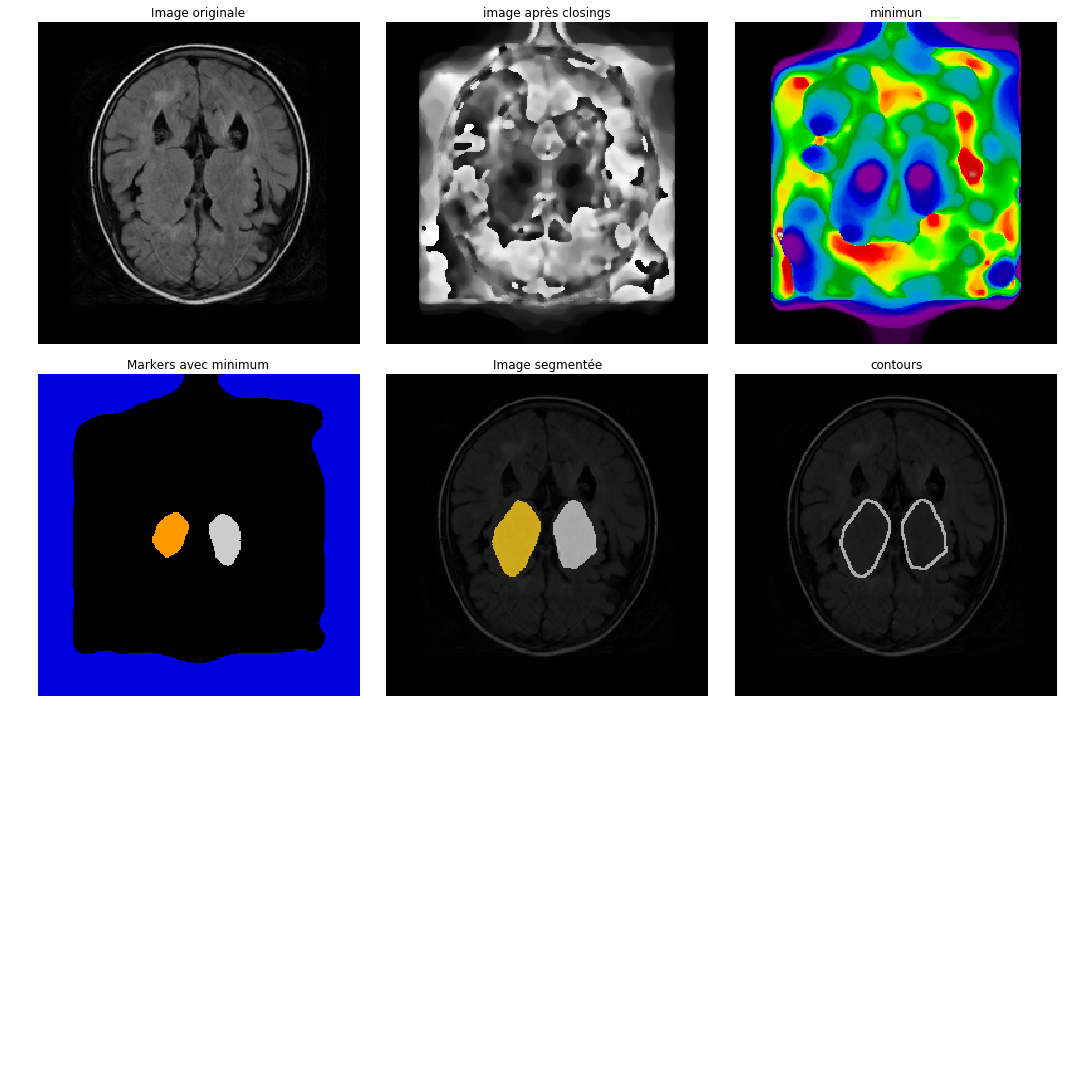

In [12]:
img =skio.imread('Image1Coupe10.png') #ouvrir l'image
image=incrclosing(1,50,3,img) #ca c'est mes fermetures croissantes (je pense pas que ça t'intéresse)

# denoise image

denoised = rank.median(image, disk(10)) #tu peux changer le disque du filtre ça rend l'image plus douce


#markers pour le minimum+etiquetage
markers=rank.minimum(denoised, disk(2))<50 #ici je sélectionne seule les pixels qui corresponde à un
#minimum local plus petit que 50 dans un disque de rayon 2



markers=ndi.label(markers)[0] #on met des étiquettes
l=trouv_mark_noyaux(markers) #je cherche les marqueurs qui correspondent à mes noyaux gris l = liste des étiquettes de marqueurs intéressants
l.append(1) #j'ajoute le fond en marqueur (to come : le contour du crane)
print(markers)
markers=clean_markers(markers,l) #j'enleve tous les markeurs qui snt pas dans l

#essai avec le minimum 
mini=rank.minimum(denoised, disk(3))#heu celui la je l'utilise pas 
mini2=rank.minimum(denoised, disk(3)) <97 #je mets un seuil de minimum pour dire celui la je l'utilise
# process the watershed
labels = watershed(mini2, markers) #segmentation par partage des eaux avec le minimum et les marqueurs


# display results
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title("Image originale")


ax[1].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title("image après closings")



ax[2].imshow(mini, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title("minimun")

ax[3].imshow(markers, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[3].set_title("Markers avec minimum")

ax[4].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
ax[4].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest', alpha=.7)
ax[4].set_title("Image segmentée")

ax[5].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
ax[5].imshow(dessinercontour(labels), cmap=plt.cm.nipy_spectral, interpolation='nearest', alpha=.7)
ax[5].set_title("contours")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

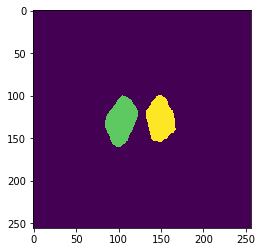

In [13]:
plt.imshow(labels)

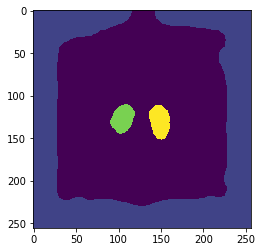

In [14]:
plt.imshow(markers)

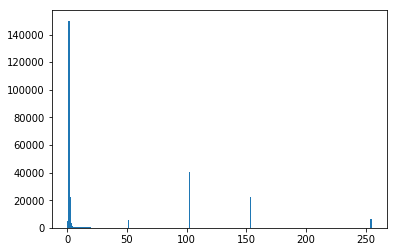

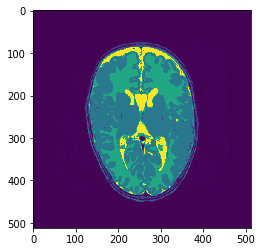

In [15]:
from PIL import Image
import imageio

def seuil(im,s):
    """ renvoie une image blanche(255) la ou im>=s et noire (0) ailleurs.
    """
    imt=np.float32(im.copy())
    mask=imt<s
    imt[mask]=0
    imt[~mask]=255
    return imt

def initialize(k) : 
    #on cherche k centres de classe. 
    #on va ranger chaque centre de la kè classe en kè pos de la liste l
    centres=[]
    #on divise l'histogramme en l parties :
    pas=255/k
    for i in range(k) : 
        centres.append(np.random.randint(i*pas,(i+1)*pas))
    return centres

def affectation(centres,img) : 
    affectation={}
    imt=np.float32(img.copy())
    k=len(centres)
    for i in range(k) : 
        if (i==0) : 
            seuil=(centres[0]+centres[1])/2
            mask=imt<seuil
            affectation[i]=mask
            
        if (i==k-1) : 
            seuil=(centres[k-2]+centres[k-1])/2
            mask=imt>seuil
            affectation[i]=mask
        else : 
            seuil1=(centres[i-1]+centres[i])/2
            seuil2=(centres[i]+centres[i+1])/2
            mask1=seuil1<imt
            mask2=imt<seuil2
            affectation[i]=np.logical_and(mask1,mask2)
    
    return affectation

def nveau_centres(centres,img,affectation) : 
    nveaux_centres=[]
    imt=np.float32(img.copy())
    for i in range(len(centres)) :
        p1=0
        p2=0
        for p in imt[affectation[i]] : 
            p1+=(centres[i]-p)**2
            p2+=p*(centres[i]-p)**2
        if p1==0: 
            nveaux_centres.append(0)
        else :
            nveaux_centres.append(p2/p1)
    return nveaux_centres

def kmeans(nbreit,img,k) : 
    centres=initialize(k)
    imt=np.float32(img.copy())
    for j in range(nbreit) : 
        a=affectation(centres,img)
        centres=nveau_centres(centres,img,a)
    for j in range(k) : 
        if (j==0) : 
            imt[a[j]]=0
        if(j==k-1) : 
            imt[a[j]]=255
        else : 
            imt[a[j]]=int(j*255/k)
    plt.hist(imt.reshape((-1,)),bins=255)
    plt.show()
    return imt

im=Image.open('T2024.png').convert('L')
img=np.asarray(im)
imageio.imwrite('T2024NB.png',img)
im= kmeans(50,img,5)
plt.imshow(im)